In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
from pathlib import Path

# Load Data

## Global Solar Atlas (TIFF)

In [2]:
pvout_path = r"C:\Users\User\Downloads\Australia_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\PVOUT.tif"

src = rasterio.open(pvout_path)

print("CRS:", src.crs)
print("Resolution:", src.res)
print("Bounds:", src.bounds)
print("Size:", src.width, "x", src.height)

CRS: EPSG:4326
Resolution: (0.008333333333333333, 0.008333333333333333)
Bounds: BoundingBox(left=112.0, bottom=-44.0, right=160.0, top=-9.0)
Size: 5760 x 4200


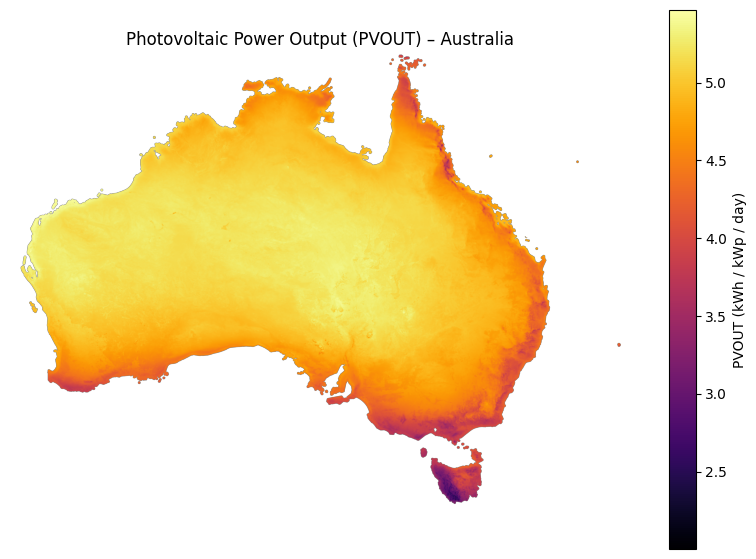

In [4]:
plt.figure(figsize=(10, 7))
plt.imshow(src.read(1), cmap="inferno")
plt.colorbar(label="PVOUT (kWh / kWp / day)")
plt.title("Photovoltaic Power Output (PVOUT) – Australia")
plt.axis("off")
plt.show()

## Kaggle (AU Weather Data)

In [5]:
path = kagglehub.dataset_download("arunavakrchakraborty/australia-weather-data")

print("Path to dataset files:", path)

C:\Users\User\anaconda3\envs\stratpoint\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 3.86M/3.86M [00:01<00:00, 3.06MB/s]

Extracting files...
Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\arunavakrchakraborty\australia-weather-data\versions\1


In [6]:
data_dir = Path(r"C:\Users\User\.cache\kagglehub\datasets\arunavakrchakraborty\australia-weather-data\versions\1")

files = sorted([p.name for p in data_dir.glob("*")])
files

['Weather Test Data.csv', 'Weather Training Data.csv']

# Identifying Cities & Creating Coords

In [9]:
train_path = data_dir / "Weather Training Data.csv"
test_path  = data_dir / "Weather Test Data.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

print("\nTrain columns:\n", train_df.columns.tolist())
print("\nTest columns:\n", test_df.columns.tolist())


Train shape: (99516, 23)
Test shape : (42677, 22)

Train columns:
 ['row ID', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']

Test columns:
 ['row ID', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


In [14]:
train_df["Location"].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

The following data were extracted from: - [Bureau of Meteorology – Climate Data Stations](https://www.bom.gov.au/climate/data/stations/) - [Bureau of Meteorology – Stations List by Element](https://www.bom.gov.au/climate/data/lists_by_element/stations.txt

In [17]:
# Extracted from "https://www.bom.gov.au/climate/data/stations/" and 
# "https://www.bom.gov.au/climate/data/lists_by_element/stations.txt"

coords_df = pd.DataFrame(
    [
        # NSW
        ("Albury",          -36.07,   146.90),
        ("BadgerysCreek",   -33.82,   150.77),
        ("Cobar",           -31.50,   145.83),
        ("CoffsHarbour",    -30.32,   153.12),
        ("Moree",           -29.47,   149.83),   # NSW
        ("Newcastle",       -32.93,   151.78),
        ("NorahHead",       -33.28,   151.57),
        ("NorfolkIsland",   -29.03,   167.95),
        ("Penrith",         -33.75,   150.69),
        ("Richmond",        -33.60,   150.75),   # NSW (Richmond RAAF)
        ("Sydney",          -33.87,   151.21),
        ("SydneyAirport",   -33.9278, 151.1700),
        ("WaggaWagga",      -35.12,   147.37),
        ("Williamtown",     -32.82,   151.84),
        ("Wollongong",      -34.43,   150.89),

        # ACT
        ("Canberra",        -35.30,   149.13),
        ("Tuggeranong",     -35.42,   149.10),
        ("MountGinini",     -35.5293, 148.7721),

        # VIC
        ("Ballarat",        -37.56,   143.85),
        ("Bendigo",         -36.76,   144.28),
        ("Sale",            -38.10,   147.07),
        ("MelbourneAirport",-37.6654, 144.8329),
        ("Melbourne",       -37.84,   144.98),
        ("Mildura",         -34.19,   142.16),
        ("Nhil",            -36.33,   141.65),
        ("Portland",        -38.34,   141.60),   # VIC
        ("Watsonia",        -37.71,   145.08),
        ("Dartmoor",        -37.92,   141.27),   # VIC

        # QLD
        ("Brisbane",        -27.47,   153.03),
        ("Cairns",          -16.92,   145.78),
        ("GoldCoast",       -28.00,   153.33),
        ("Townsville",      -19.26,   146.82),

        # SA
        ("Adelaide",        -34.93,   138.60),
        ("MountGambier",    -37.82,   140.78),
        ("Nuriootpa",       -34.47,   139.00),
        ("Woomera",         -31.17,   136.81),

        # WA
        ("Albany",          -35.02,   117.88),
        ("Witchcliffe",     -34.02,   115.10),
        ("PearceRAAF",      -31.6669, 116.0189),
        ("PerthAirport",    -31.9275, 115.9764),
        ("Perth",           -31.95,   115.86),   # WA
        ("SalmonGums",      -32.98,   121.64),
        ("Walpole",         -34.98,   116.73),

        # TAS
        ("Hobart",          -42.88,   147.32),
        ("Launceston",      -41.44,   147.14),

        # NT
        ("AliceSprings",    -23.70,   133.88),
        ("Darwin",          -12.46,   130.84),
        ("Katherine",       -14.47,   132.27),
        ("Uluru",           -25.3444, 131.0369),
    ],
    columns=["Location", "Lat", "Lon"]
)

In [16]:
assert coords_df["Location"].is_unique, "Duplicate Location entries found"
assert coords_df.shape[0] == 49, f"Expected 49 locations, got {coords_df.shape[0]}"
assert coords_df["Lat"].between(-45, -9).all(), "Latitude out of Australia bounds"
assert coords_df["Lon"].between(110, 170).all(), "Longitude out of Australia bounds"

coords_df = coords_df.sort_values("Location").reset_index(drop=True)
coords_df

,Location,Lat,Lon
0,Adelaide,-34.9300,138.6000
1,Albany,-35.0200,117.8800
2,Albury,-36.0700,146.9000
3,AliceSprings,-23.7000,133.8800
4,BadgerysCreek,-33.8200,150.7700
5,Ballarat,-37.5600,143.8500
6,Bendigo,-36.7600,144.2800
7,Brisbane,-27.4700,153.0300
8,Cairns,-16.9200,145.7800
9,Canberra,-35.3000,149.1300


Below computes the mean photovoltaic output (PVOUT) around given coordinates using a GeoTIFF raster. 

1. **Input Data** - A `coords_df` DataFrame containing: - `Location` - `Lat` (negative for southern hemisphere) - `Lon` (positive for eastern hemisphere) - Path to a PVOUT GeoTIFF (`tif_path`). 

2. **Function: `extract_pvout_mean`** - Converts each `(Lat, Lon)` into raster indices. - Builds a square pixel window of size `(2 × buffer_px + 1)` around the point. - Reads raster values within the window, handling nodata values. - Computes: - `pvout_mean` (average PVOUT) - `pvout_std` (standard deviation) - `n_valid` (number of valid pixels) - `window_px` (window size in pixels) - Flags results with `pvout_ok` if mean PVOUT is between 0 and 10.
3. **Output** - A DataFrame with enriched PVOUT statistics for each location

In [32]:
def extract_pvout_mean(
    coords_df: pd.DataFrame,
    tif_path: str,
    buffer_px: int = 3,
    band: int = 1,
) -> pd.DataFrame:
    """
    Extract mean PVOUT around each (Lat, Lon) in coords_df using a square pixel window.
    Parameters
    ----------
    coords_df : pd.DataFrame
        Must contain columns: ["Location", "Lat", "Lon"].
        Lat should be negative for southern hemisphere; Lon positive for eastern hemisphere.
    tif_path : str
        Path to PVOUT GeoTIFF.
    buffer_px : int, default=3
        Window radius in pixels.
        The window size is (2*buffer_px + 1) x (2*buffer_px + 1).
        Example: buffer_px=3 -> 7x7 window.
    band : int, default=1
        Raster band index to read.
    Returns
    -------
    pd.DataFrame
        Columns:
          - Location
          - Lat
          - Lon
          - pvout_mean
          - pvout_std
          - n_valid
          - window_px
    """
    required = {"Location", "Lat", "Lon"}
    missing = required - set(coords_df.columns)
    if missing:
        raise ValueError(f"coords_df missing columns: {missing}")
    
    rows = []
    with rasterio.open(tif_path) as src:
        for _, r in coords_df.iterrows():
            loc = r["Location"]
            lat = float(r["Lat"])
            lon = float(r["Lon"])
            
            # Convert lon/lat to raster row/col
            try:
                row, col = src.index(lon, lat)
            except Exception as e:
                rows.append({
                    "Location": loc, "Lat": lat, "Lon": lon,
                    "pvout_mean": np.nan, "pvout_std": np.nan, "n_valid": 0,
                    "window_px": 2*buffer_px + 1, "error": f"index_error: {e}"
                })
                continue
            
            # Check if point is within raster bounds
            if not (0 <= row < src.height and 0 <= col < src.width):
                rows.append({
                    "Location": loc, "Lat": lat, "Lon": lon,
                    "pvout_mean": np.nan, "pvout_std": np.nan, "n_valid": 0,
                    "window_px": 2*buffer_px + 1, "error": "out_of_bounds"
                })
                continue
            
            # Build window around the pixel
            col_off = max(0, col - buffer_px)
            row_off = max(0, row - buffer_px)
            
            # Calculate actual window size (may be smaller near edges)
            width = min(2 * buffer_px + 1, src.width - col_off)
            height = min(2 * buffer_px + 1, src.height - row_off)
            
            # Adjust offset if window would extend past right/bottom edge
            if col + buffer_px >= src.width:
                col_off = max(0, src.width - (2 * buffer_px + 1))
                width = src.width - col_off
            
            if row + buffer_px >= src.height:
                row_off = max(0, src.height - (2 * buffer_px + 1))
                height = src.height - row_off
            
            w = Window(col_off=col_off, row_off=row_off, width=width, height=height)
            
            # Read masked array to handle nodata cleanly
            arr = src.read(band, window=w, masked=True)
            vals = arr.astype("float64").filled(np.nan)
            
            # Stats
            valid = np.isfinite(vals)
            n_valid = int(valid.sum())
            pvout_mean = float(np.nanmean(vals)) if n_valid > 0 else np.nan
            pvout_std = float(np.nanstd(vals)) if n_valid > 0 else np.nan
            
            rows.append({
                "Location": loc, "Lat": lat, "Lon": lon,
                "pvout_mean": pvout_mean, "pvout_std": pvout_std,
                "n_valid": n_valid, "window_px": 2 * buffer_px + 1,
            })
    
    out = pd.DataFrame(rows)
    out["pvout_ok"] = out["pvout_mean"].between(0, 10)
    return out

In [33]:
pvout_by_location_df = extract_pvout_mean(
    coords_df=coords_df,
    tif_path=PVOUT_TIF_PATH,
    buffer_px=3,
)

pvout_by_location_df.sort_values("pvout_mean", ascending=False).head(10)

,Location,Lat,Lon,pvout_mean,pvout_std,n_valid,window_px,error,pvout_ok
45,AliceSprings,-23.7000,133.8800,5.246265,0.005142,49,7,NaN,True
48,Uluru,-25.3444,131.0369,5.205429,0.025040,49,7,NaN,True
35,Woomera,-31.1700,136.8100,5.057347,0.007860,49,7,NaN,True
47,Katherine,-14.4700,132.2700,4.966449,0.002442,49,7,NaN,True
2,Cobar,-31.5000,145.8300,4.890980,0.012263,49,7,NaN,True
4,Moree,-29.4700,149.8300,4.860796,0.003954,49,7,NaN,True
31,Townsville,-19.2600,146.8200,4.790204,0.020627,49,7,NaN,True
40,Perth,-31.9500,115.8600,4.760878,0.034448,49,7,NaN,True
38,PearceRAAF,-31.6669,116.0189,4.739673,0.011356,49,7,NaN,True
23,Mildura,-34.1900,142.1600,4.732469,0.010765,49,7,NaN,True


# Creating Dataset

The final model was trained exclusively on the **training subset** of the weather dataset. To ensure reliability, we later performed a sanity check to verify that the city coverage and feature distributions remained consistent across the dataset.

## Train Only

In [35]:
w = train_df.copy()
num_cols = [
    "MinTemp","MaxTemp","Rainfall","Evaporation","Sunshine",
    "WindGustSpeed","WindSpeed9am","WindSpeed3pm",
    "Humidity9am","Humidity3pm","Pressure9am","Pressure3pm",
    "Cloud9am","Cloud3pm","Temp9am","Temp3pm"
]

In [51]:
missing_counts = w.isna().sum()
print(missing_counts)
print("\nTotal rows:", len(w))

row ID               0
Location             0
MinTemp            443
MaxTemp            230
Rainfall           979
Evaporation      42531
Sunshine         47317
WindGustDir       6521
WindGustSpeed     6480
WindDir9am        7006
WindDir3pm        2648
WindSpeed9am       935
WindSpeed3pm      1835
Humidity9am       1233
Humidity3pm       2506
Pressure9am       9748
Pressure3pm       9736
Cloud9am         37572
Cloud3pm         40002
Temp9am            614
Temp3pm           1904
RainToday          979
RainTomorrow         0
dtype: int64

Total rows: 99516


In [36]:
for c in num_cols:
    if c in w.columns:
        w[c] = pd.to_numeric(w[c], errors="coerce")

In [38]:
agg = (
    w.groupby("Location", as_index=False)
     .agg(
         n_obs=("Location", "size"),

         MinTemp_mean=("MinTemp","mean"),
         MaxTemp_mean=("MaxTemp","mean"),
         Temp9am_mean=("Temp9am","mean"),
         Temp3pm_mean=("Temp3pm","mean"),

         Humidity9am_mean=("Humidity9am","mean"),
         Humidity3pm_mean=("Humidity3pm","mean"),

         Pressure9am_mean=("Pressure9am","mean"),
         Pressure3pm_mean=("Pressure3pm","mean"),

         Cloud9am_mean=("Cloud9am","mean"),
         Cloud3pm_mean=("Cloud3pm","mean"),

         WindGustSpeed_mean=("WindGustSpeed","mean"),
         WindSpeed9am_mean=("WindSpeed9am","mean"),
         WindSpeed3pm_mean=("WindSpeed3pm","mean"),

         Rainfall_mean=("Rainfall","mean"),
         Evaporation_mean=("Evaporation","mean"),
         Sunshine_mean=("Sunshine","mean")
     )
)

In [39]:
agg

,Location,n_obs,MinTemp_mean,MaxTemp_mean,Temp9am_mean,Temp3pm_mean,Humidity9am_mean,Humidity3pm_mean,Pressure9am_mean,Pressure3pm_mean,Cloud9am_mean,Cloud3pm_mean,WindGustSpeed_mean,WindSpeed9am_mean,WindSpeed3pm_mean,Rainfall_mean,Evaporation_mean,Sunshine_mean
0,Adelaide,2178,12.525310,22.781066,16.831494,21.449425,60.069885,44.996780,1018.711551,1016.777773,NaN,NaN,36.503238,9.998160,15.519319,1.525542,5.756787,7.755278
1,Albany,2051,12.901591,20.003744,16.196347,18.333291,74.835562,67.520886,1018.372616,1016.584562,5.176616,4.895833,NaN,12.536779,18.907702,2.208440,4.215546,6.629656
2,Albury,2142,9.497053,22.529285,14.275105,21.260122,74.312004,48.103319,1018.382073,1015.760215,6.417749,5.476000,32.854733,8.200561,14.403648,2.039531,NaN,NaN
3,AliceSprings,2119,13.219641,29.295517,21.379000,28.058263,39.834121,24.253901,1016.610104,1012.804487,2.867129,3.273656,40.460287,14.659112,18.018886,0.881268,9.024094,9.545709
4,BadgerysCreek,2041,11.132579,23.962187,16.543886,22.464561,76.769955,51.163609,1018.577680,1015.764876,NaN,NaN,33.496796,8.088845,13.978744,2.115542,NaN,NaN
5,Ballarat,2122,7.284866,18.234276,11.622196,16.760057,81.750831,58.847426,1018.170764,1016.554869,5.836900,6.285094,44.641940,19.880851,22.706604,1.523724,NaN,NaN
6,Bendigo,2110,8.524550,21.429587,13.753791,20.067805,70.756167,46.859175,1018.058306,1015.922613,4.425000,4.858391,38.867499,12.971049,17.238253,1.556906,3.754054,NaN
7,Brisbane,2202,16.374989,26.411874,21.802363,24.725114,63.857338,53.660438,1018.289373,1015.144389,3.917310,3.870059,28.229433,6.990917,10.955475,3.170340,5.413111,8.096908
8,Cairns,2101,21.176868,29.532889,25.777535,27.880485,69.971918,61.711566,1014.122180,1011.070062,4.577157,4.430973,38.111537,15.966683,21.949048,5.661007,6.252295,7.584179
9,Canberra,2393,6.790928,20.999749,12.663770,19.482991,73.111537,45.634075,1019.018837,1016.271793,4.887333,4.849426,39.959240,10.437360,19.101703,1.736176,4.470935,7.411939


In [52]:
target = pvout_by_location_df[["Location", "pvout_mean"]].copy()

model_df = (
    agg.merge(target, on="Location", how="inner")
       .sort_values("Location")
       .reset_index(drop=True)
)

In [53]:
model_df

,Location,n_obs,MinTemp_mean,MaxTemp_mean,Temp9am_mean,Temp3pm_mean,Humidity9am_mean,Humidity3pm_mean,Pressure9am_mean,Pressure3pm_mean,Cloud9am_mean,Cloud3pm_mean,WindGustSpeed_mean,WindSpeed9am_mean,WindSpeed3pm_mean,Rainfall_mean,Evaporation_mean,Sunshine_mean,pvout_mean
0,Adelaide,2178,12.525310,22.781066,16.831494,21.449425,60.069885,44.996780,1018.711551,1016.777773,NaN,NaN,36.503238,9.998160,15.519319,1.525542,5.756787,7.755278,4.384775
1,Albany,2051,12.901591,20.003744,16.196347,18.333291,74.835562,67.520886,1018.372616,1016.584562,5.176616,4.895833,NaN,12.536779,18.907702,2.208440,4.215546,6.629656,3.844816
2,Albury,2142,9.497053,22.529285,14.275105,21.260122,74.312004,48.103319,1018.382073,1015.760215,6.417749,5.476000,32.854733,8.200561,14.403648,2.039531,NaN,NaN,4.444959
3,AliceSprings,2119,13.219641,29.295517,21.379000,28.058263,39.834121,24.253901,1016.610104,1012.804487,2.867129,3.273656,40.460287,14.659112,18.018886,0.881268,9.024094,9.545709,5.246265
4,BadgerysCreek,2041,11.132579,23.962187,16.543886,22.464561,76.769955,51.163609,1018.577680,1015.764876,NaN,NaN,33.496796,8.088845,13.978744,2.115542,NaN,NaN,4.167959
5,Ballarat,2122,7.284866,18.234276,11.622196,16.760057,81.750831,58.847426,1018.170764,1016.554869,5.836900,6.285094,44.641940,19.880851,22.706604,1.523724,NaN,NaN,3.912061
6,Bendigo,2110,8.524550,21.429587,13.753791,20.067805,70.756167,46.859175,1018.058306,1015.922613,4.425000,4.858391,38.867499,12.971049,17.238253,1.556906,3.754054,NaN,4.357367
7,Brisbane,2202,16.374989,26.411874,21.802363,24.725114,63.857338,53.660438,1018.289373,1015.144389,3.917310,3.870059,28.229433,6.990917,10.955475,3.170340,5.413111,8.096908,4.356816
8,Cairns,2101,21.176868,29.532889,25.777535,27.880485,69.971918,61.711566,1014.122180,1011.070062,4.577157,4.430973,38.111537,15.966683,21.949048,5.661007,6.252295,7.584179,4.397265
9,Canberra,2393,6.790928,20.999749,12.663770,19.482991,73.111537,45.634075,1019.018837,1016.271793,4.887333,4.849426,39.959240,10.437360,19.101703,1.736176,4.470935,7.411939,4.528408


In [54]:
print("Unique locations in TRAIN weather:", agg.shape[0])
print("Unique locations in PVOUT:", target.shape[0])
print("Final merged rows:", model_df.shape[0])

missing = sorted(set(target["Location"]) - set(model_df["Location"]))
if missing:
    print("WARNING: Missing locations after merge:", missing)

assert model_df.shape[0] == 49, f"Expected 49 rows, got {model_df.shape[0]}"

print("\nTop NA rates:")
print(model_df.isna().mean().sort_values(ascending=False).head(10))

Unique locations in TRAIN weather: 49
Unique locations in PVOUT: 49
Final merged rows: 49

Top NA rates:
Sunshine_mean         0.387755
Evaporation_mean      0.326531
Cloud9am_mean         0.244898
Cloud3pm_mean         0.244898
Pressure3pm_mean      0.081633
Pressure9am_mean      0.081633
WindGustSpeed_mean    0.040816
pvout_mean            0.020408
MinTemp_mean          0.000000
Location              0.000000
dtype: float64


In [55]:
model_df[model_df["pvout_mean"].isna()]

,Location,n_obs,MinTemp_mean,MaxTemp_mean,Temp9am_mean,Temp3pm_mean,Humidity9am_mean,Humidity3pm_mean,Pressure9am_mean,Pressure3pm_mean,Cloud9am_mean,Cloud3pm_mean,WindGustSpeed_mean,WindSpeed9am_mean,WindSpeed3pm_mean,Rainfall_mean,Evaporation_mean,Sunshine_mean,pvout_mean
27,NorfolkIsland,2038,16.804122,21.770658,19.692776,20.411051,70.859951,67.748527,1017.694587,1015.938016,5.044,4.847041,42.388779,20.045231,21.818762,3.092,4.761392,6.990611,NaN


In [57]:
with rasterio.open(pvout_path) as src:
    print("Raster bounds:", src.bounds)
    print("Norfolk Island in bounds?",
          src.bounds.left <= 167.95 <= src.bounds.right and
          src.bounds.bottom <= -29.03 <= src.bounds.top)

Raster bounds: BoundingBox(left=112.0, bottom=-44.0, right=160.0, top=-9.0)
Norfolk Island in bounds? False


In [58]:
model_df = model_df[model_df["Location"] != "NorfolkIsland"].reset_index(drop=True)

In [60]:
# model_df.to_csv("dataset_train_only.csv", index=False)
# print("Saved dataset_train_only.csv")

Saved dataset_train_only.csv


## Train + Test Sanity Check

In [62]:
weather_all = pd.concat([train_df, test_df], ignore_index=True)
w = weather_all.copy()

In [63]:
for c in num_cols:
    if c in w.columns:
        w[c] = pd.to_numeric(w[c], errors="coerce")

In [64]:
agg_all = (
    w.groupby("Location", as_index=False)
     .agg(
         n_obs=("Location", "size"),

         MinTemp_mean=("MinTemp","mean"),
         MaxTemp_mean=("MaxTemp","mean"),
         Temp9am_mean=("Temp9am","mean"),
         Temp3pm_mean=("Temp3pm","mean"),

         Humidity9am_mean=("Humidity9am","mean"),
         Humidity3pm_mean=("Humidity3pm","mean"),

         Pressure9am_mean=("Pressure9am","mean"),
         Pressure3pm_mean=("Pressure3pm","mean"),

         Cloud9am_mean=("Cloud9am","mean"),
         Cloud3pm_mean=("Cloud3pm","mean"),

         WindGustSpeed_mean=("WindGustSpeed","mean"),
         WindSpeed9am_mean=("WindSpeed9am","mean"),
         WindSpeed3pm_mean=("WindSpeed3pm","mean"),

         Rainfall_mean=("Rainfall","mean"),
         Evaporation_mean=("Evaporation","mean"),
         Sunshine_mean=("Sunshine","mean"),

     )
)

In [65]:
dataset_B = (
    agg_all
    .merge(
        model_df[["Location", "pvout_mean"]],  # reuse cleaned target
        on="Location",
        how="inner"
    )
    .query("Location != 'NorfolkIsland'")
    .sort_values("Location")
    .reset_index(drop=True)
)


In [67]:
dataset_B

,Location,n_obs,MinTemp_mean,MaxTemp_mean,Temp9am_mean,Temp3pm_mean,Humidity9am_mean,Humidity3pm_mean,Pressure9am_mean,Pressure3pm_mean,Cloud9am_mean,Cloud3pm_mean,WindGustSpeed_mean,WindSpeed9am_mean,WindSpeed3pm_mean,Rainfall_mean,Evaporation_mean,Sunshine_mean,pvout_mean
0,Adelaide,3090,12.628368,22.945402,16.973193,21.603953,59.618476,44.820097,1018.727579,1016.772202,NaN,NaN,36.530812,9.954295,15.470665,1.572185,5.824924,7.752002,4.384775
1,Albany,3016,12.948461,20.072587,16.233154,18.412974,74.820202,67.392487,1018.283049,1016.500668,5.190876,4.808703,NaN,12.498986,19.001305,2.255073,4.207273,6.658765,3.844816
2,Albury,3011,9.520899,22.630963,14.348620,21.364716,74.108081,47.884935,1018.367253,1015.755504,6.392356,5.419788,32.953016,8.221816,14.378828,1.925710,NaN,NaN,4.444959
3,AliceSprings,3031,13.125182,29.244191,21.328868,28.008452,39.625165,24.078321,1016.699670,1012.884478,2.839200,3.245791,40.533714,14.728623,18.103665,0.869355,9.029929,9.581944,5.246265
4,BadgerysCreek,2928,11.136900,24.023111,16.574141,22.516644,76.893067,51.426648,1018.450880,1015.632806,NaN,NaN,33.609890,8.047488,14.008262,2.207925,NaN,NaN,4.167959
5,Ballarat,3028,7.355302,18.274794,11.664125,16.776447,81.816428,59.045665,1017.855293,1016.274967,5.797101,6.286865,44.978695,19.978477,22.780496,1.688830,NaN,NaN,3.912061
6,Bendigo,3034,8.591065,21.616683,13.844789,20.249885,70.543084,46.472140,1018.024272,1015.869521,4.396618,4.857080,38.849283,12.934675,17.157374,1.621452,3.851730,NaN,4.357367
7,Brisbane,3161,16.410998,26.441527,21.829186,24.742354,64.014878,53.862627,1018.246947,1015.116714,3.918354,3.879076,28.211380,6.950965,11.000633,3.160536,5.408848,8.082782,4.356816
8,Cairns,2988,21.199197,29.544344,25.799465,27.896653,69.902276,61.677376,1014.154284,1011.103447,4.557974,4.429907,38.067991,15.926372,21.927017,5.765317,6.211976,7.575995,4.397265
9,Canberra,3418,6.827688,20.980644,12.681594,19.477016,73.216562,45.832648,1018.986725,1016.235272,4.873724,4.789279,40.082174,10.415987,19.125822,1.735038,4.404717,7.403241,4.528408


In [66]:
print("NA rates — Dataset A")
print(model_df.isna().mean().sort_values(ascending=False).head(6))

print("\nNA rates — Dataset B")
print(dataset_B.isna().mean().sort_values(ascending=False).head(6))


NA rates — Dataset A
Sunshine_mean       0.395833
Evaporation_mean    0.333333
Cloud9am_mean       0.250000
Cloud3pm_mean       0.250000
Pressure3pm_mean    0.083333
Pressure9am_mean    0.083333
dtype: float64

NA rates — Dataset B
Sunshine_mean       0.395833
Evaporation_mean    0.333333
Cloud9am_mean       0.250000
Cloud3pm_mean       0.250000
Pressure3pm_mean    0.083333
Pressure9am_mean    0.083333
dtype: float64
